In [116]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm


import math

In [117]:
df = pd.read_csv("Dataset\housing.csv")
df.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [118]:
class PreprocessingClass:
    def __init__(self, data, target_var, test_split_ratio = 0.2, stratify = False) -> None:

        self.data = data
        self.target_var = target_var
        self.test_split_ratio = test_split_ratio
        self.stratify = stratify

    def train_test_split_data(self, X, y):
        if self.stratify:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X ,y ,test_size= self.test_split_ratio, 
                                                                                    stratify= y, random_state= 42)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X ,y ,
                                                                                    test_size= self.test_split_ratio, random_state= 42)
    
    def train_normalize(self, X):
        mean = X.mean()
        std = X.std()
        X = (X - mean)/std
        return X, mean, std
    
    def test_normalize(self, X, mean, std):
        X = (X - mean)/std
        return X
    

    def fit(self):
        self.X_data = self.data.drop([self.target_var], axis = 1)
        self.y_data = self.data[self.target_var]

        self.train_test_split_data(self.X_data, self.y_data)
        
        self.X_train, mean, std = self.train_normalize(self.X_train)
        self.X_test = self.test_normalize(self.X_test, mean, std)

In [119]:
ppc = PreprocessingClass(data= df, target_var= "24", test_split_ratio = 0.3)
ppc.fit()

X_train, X_test, y_train, y_test = ppc.X_train, ppc.X_test, ppc.y_train, ppc.y_test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 13), (152, 13), (353,), (152,))

In [120]:
class LinearRegressionClass:
    def __init__(self, data, target, learning_rate = 0.00005, epsilon = 1e-8, 
                 max_iterations= 1000, method = "closed", loss_function_type = "L2", 
                 huber_delta = 1, reg_type = None, reg_lambda = 0, print_log = False, fit_intercept = True) -> None:
         
        """
        @data: pandas dataframe or np.array, Passed data,

        @does: ,
        @return: ,
        """
        
        self.fit_intercept = fit_intercept
        self.X = np.insert(data.to_numpy(),0,1,axis=1) if self.fit_intercept == True else data.to_numpy()
        self.y = target.to_numpy()
        self.loss_function_type = loss_function_type
        self.reg_type = reg_type
        self.reg_lambda = 0 if self.reg_type == None else reg_lambda
        self.learning_rate = learning_rate
        self.huber_delta = huber_delta
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.method = method
        self.weight = None
        
        self.print_log = print_log
    
    def rank(self):
        u, sigma, v = np.linalg.svd(self.X)
        return np.count_nonzero(sigma > 0)
    

    def linear_regression_closed_form(self):
        self.weight = np.matmul(np.linalg.inv(np.matmul(self.X.T , self.X)), np.matmul(self.X.T, self.y))

    def predict(self, X):
        return np.matmul(X, self.weight)

    def loss_functions(self, X, y):
        y_hat = self.predict(X)
        if self.loss_function_type == "L2":
            return (0.5 * (y_hat - y) ** 2).sum()
        
        if self.loss_function_type == "L1":
            return (abs(y_hat - y)).sum()
        
        if self.loss_function_type == "huber":
            huber_mse = 0.5*((y_hat - y) ** 2)
            huber_mae = self.huber_delta * (abs(y_hat - y) - 0.5 * self.huber_delta)
            return (np.where(np.abs(y - y_hat) <= self.huber_delta, huber_mse, huber_mae)).sum()


    def derivative_loss_functions(self, X, y):
        y_hat = self.predict(X)
        if self.loss_function_type == "L2":
            return np.matmul(X.T, (y_hat - y))
        
        if self.loss_function_type == "L1":
            return np.matmul(X.T, np.sign(y_hat - y))
        
        if self.loss_function_type == "huber":
            return np.where(np.abs(y_hat - y) <= self.huber_delta, np.matmul(X.T, (y_hat - y)) , self.huber_delta * np.matmul(X.T, np.sign(y_hat - y)))
        
    def reg_functions(self):
        if self.reg_type == "L2":
            return ((self.weight) ** 2).sum()
        
        if self.reg_type == "L1":
            return (abs(self.weight)).sum()
        else:
            return 0

    def derivative_reg_functions(self):

        if self.reg_type == "L2":
            return 2* self.weight
        
        if self.reg_type == "L1":
            return np.sign(self.weight)
        
        else:
            return 0
        
    def gradient_descent(self, X, y):
        costs = []
        iterations = []
        previous_cost = math.inf
        for iter in tqdm(range(1, self.max_iterations)):
            
            if self.method == "sgd":
                X_train, X_test, y_train, y_test = train_test_split(X ,y , train_size=0.1)
            
            elif self.method == "gd":
                X_train, y_train = X, y
            
            else:
                X_train, y_train = X, y
            
            step = self.learning_rate * (self.derivative_loss_functions(X_train, y_train) + self.reg_lambda * self.derivative_reg_functions())
            
            self.weight = self.weight - step
            
            #current_cost = ((self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions())/X_train.shape[0]) ** 0.5
            current_cost = (self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions())
            
            #print(current_cost)
            costs.append(current_cost)
            iterations.append(iter)
            
            if self.print_log:
                print("Step : " + str(iter) + ": ","\n")
                print("\t" + "change ",step, "\n")
                print("current_weights: ", self.weight)
                print("current_cost: ", current_cost)
                print("current_cost_change: ", abs(current_cost - previous_cost), "\n")
            
            if abs(current_cost - previous_cost) < self.epsilon:
                print("Done")
                break
            previous_cost = current_cost
        self.fig_plot(x_data = iterations, y_data = costs)
    

    def fit(self):

        if self.X.shape[0] <1000 and self.method == "closed" and (self.rank() == self.X.shape[1]) and (self.X.shape[0] > self.X.shape[1]):
            self.linear_regression_closed_form()
            print("Closed Form used")
            print(self.weight)
        else:
            #self.weight = np.random.randn(self.X.shape[1])
            self.weight = np.zeros(self.X.shape[1])
            self.gradient_descent(self.X, self.y)
            print("Gradient descent used")
            print(self.weight)

    def fig_plot(self, x_data, y_data):
        sns.lineplot(x= x_data, y= y_data)

In [121]:
solver = LinearRegressionClass(data= X_train, target= y_train)
solver.fit()

Closed Form used
[23.09603399 -0.92471351  0.83903177  0.21691447  0.66419936 -2.03687948
  2.92064401  0.38972029 -2.92284537  2.58394111 -1.59491197 -2.36727378
  1.16320876 -4.11720415]


  1%|          | 325/49999 [00:00<00:00, 81251.05it/s]

Done
Gradient descent used
[23.09603399 -0.91742602  0.82475457  0.18457018  0.66963013 -2.02995468
  2.92793321  0.38232307 -2.92286538  2.48475277 -1.48846015 -2.36321628
  1.16099566 -4.11196379]


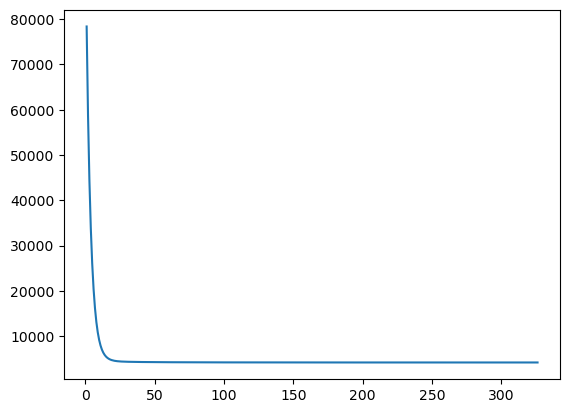

In [122]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-3, epsilon = 0.5e-2, method = "gd", 
                               max_iterations = 50000, loss_function_type = "L2")
solver.fit()

100%|██████████| 49999/49999 [00:03<00:00, 14885.21it/s]


Gradient descent used
[23.08558484 -0.76373155  0.5553121  -0.15506631  0.7377391  -1.38469607
  3.14834463  0.1790681  -2.50287753  1.3277434  -0.49944449 -2.18231158
  1.14612917 -4.01167989]


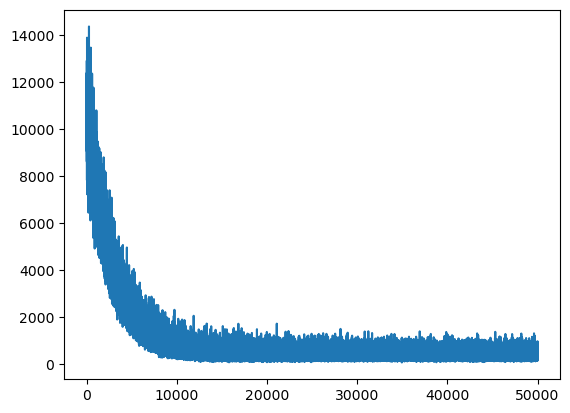

In [123]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, epsilon = 0.0000001, method = "sgd", 
                               max_iterations = 50000, loss_function_type = "L2")
solver.fit()

 99%|█████████▉| 49611/49999 [00:00<00:00, 64063.85it/s]


Done
Gradient descent used
[22.96591549 -0.90276457  0.8001415   0.1610116   0.67626022 -1.95293481
  2.94072726  0.36276841 -2.85271763  2.39839571 -1.44207772 -2.33564205
  1.15549835 -4.07929928]


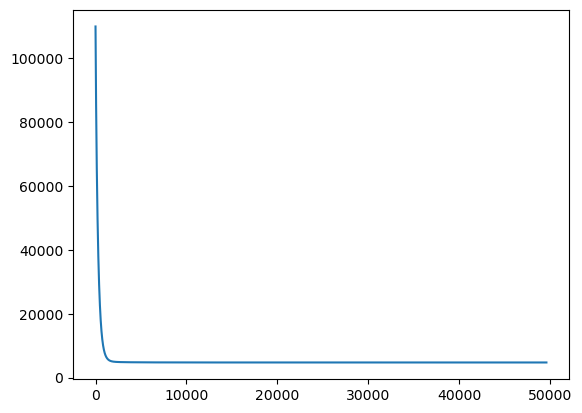

In [124]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, 
                               epsilon = 0.0000001, method = "gd", max_iterations = 50000, 
                               loss_function_type = "L2", reg_type = "L2", reg_lambda = 1)
solver.fit()

100%|██████████| 49999/49999 [00:03<00:00, 14216.86it/s]


Gradient descent used
[21.84866659 -0.71779191  0.47407969 -0.21870294  0.77581837 -1.14275997
  3.12511849  0.14117858 -2.16309593  1.05612877 -0.44130923 -2.04619498
  1.10025703 -3.77596149]


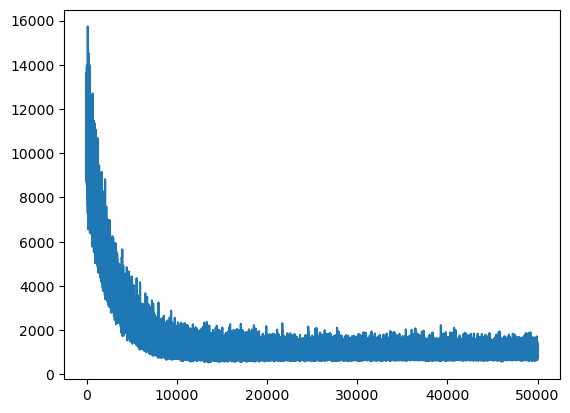

In [125]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, 
                               epsilon = 0.0000001, method = "sgd", max_iterations = 50000, 
                               loss_function_type = "L2", reg_type = "L2", reg_lambda = 1)
solver.fit()

 73%|███████▎  | 36284/49999 [00:00<00:00, 85674.03it/s]


Done
Gradient descent used
[22.044405   -1.20282033  0.4208415   0.10053832  0.38800138 -0.68793498
  4.05326173 -0.68726496 -1.8059403   0.67887642 -0.5681445  -1.83012654
  1.32785702 -2.49872309]


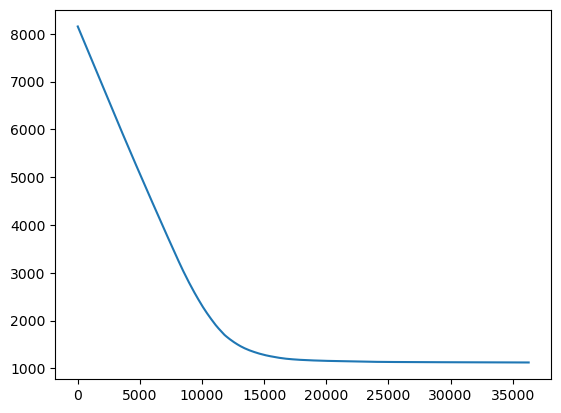

In [126]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, epsilon = 0.0000001, method = "gd", 
                               max_iterations = 50000, loss_function_type = "L1")
solver.fit()

100%|██████████| 49999/49999 [00:03<00:00, 15195.56it/s]


Gradient descent used
[ 8.690795   -0.22602881  0.0255451  -0.05428971  0.01985939 -0.06352996
  0.03145831 -0.05499045  0.06023398 -0.08721928 -0.0804201  -0.0446427
  0.01382196 -0.11366788]


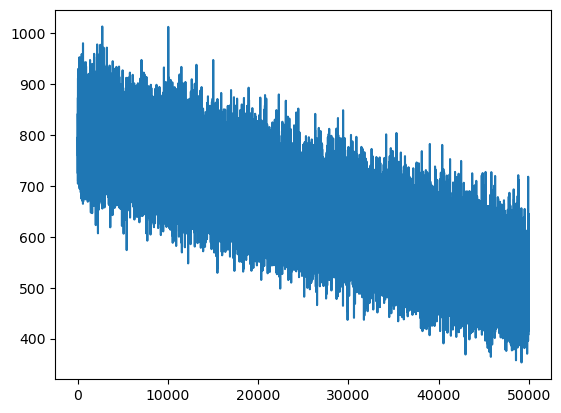

In [127]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, epsilon = 0.0000001, method = "sgd", 
                               max_iterations = 50000, loss_function_type = "L1")
solver.fit()

 71%|███████   | 35534/49999 [00:00<00:00, 73468.28it/s]


Done
Gradient descent used
[22.03852    -1.18645311  0.38391101  0.06203276  0.40431634 -0.63329437
  4.02883902 -0.66474165 -1.7556298   0.60834267 -0.54892908 -1.82807003
  1.29213655 -2.53702888]


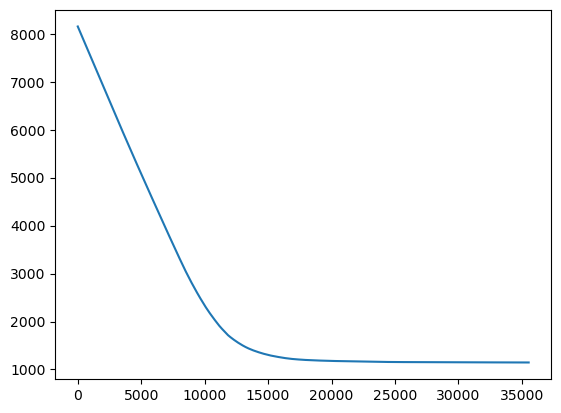

In [128]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, 
                               epsilon = 0.0000001, method = "gd", max_iterations = 50000, 
                               loss_function_type = "L1", reg_type = "L1", reg_lambda = 0.5)
solver.fit()

100%|██████████| 49999/49999 [00:03<00:00, 14656.34it/s]


Gradient descent used
[ 8.55870000e+00 -1.88965079e-01  3.22347516e-03 -2.70249021e-02
  3.07035345e-04 -2.99420706e-02  5.29936794e-03 -1.99787062e-02
  2.56250112e-02 -5.89205685e-02 -5.27924518e-02 -1.70778153e-02
  2.04238913e-02 -8.60018594e-02]


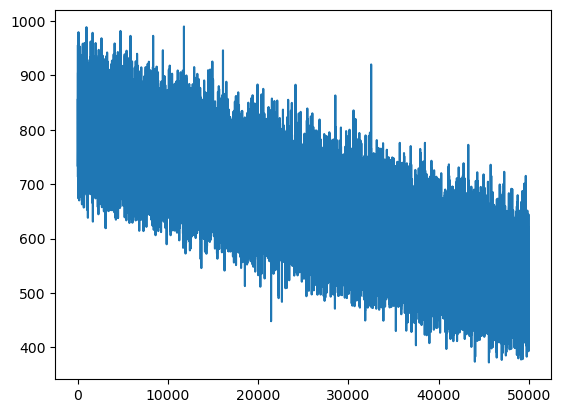

In [129]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.000005, 
                               epsilon = 0.0000001, method = "sgd", max_iterations = 50000, 
                               loss_function_type = "L1", reg_type = "L1", reg_lambda = 0.5)
solver.fit()

In [130]:
df1 = pd.read_csv("Dataset\yachtData.csv")
df1.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [131]:
ppc = PreprocessingClass(data= df1, target_var= "0.11", test_split_ratio = 0.3)
ppc.fit()

X_train, X_test, y_train, y_test = ppc.X_train, ppc.X_test, ppc.y_train, ppc.y_test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214, 6), (93, 6), (214,), (93,))

In [132]:
solver = LinearRegressionClass(data= X_train, target= y_train)
solver.fit()

Closed Form used
[11.77457944  0.2403834   0.13881857  0.51531365 -0.59566118 -0.84890487
 12.97268282]


100%|██████████| 49999/49999 [00:00<00:00, 96184.08it/s]


Gradient descent used
[11.71868198  0.25668606 -0.03891877 -0.07922586 -0.06374512 -0.24215357
 12.9098823 ]


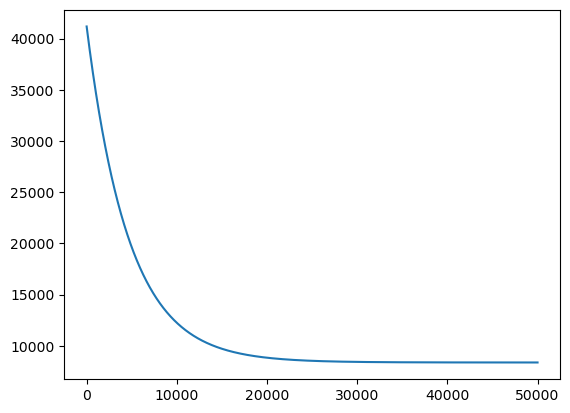

In [133]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.0000005, 
                               epsilon = 0.0000001, method = "gd", max_iterations = 50000)
solver.fit()

100%|██████████| 49999/49999 [00:03<00:00, 15789.89it/s]


Gradient descent used
[ 4.80103592  0.28918861 -0.10974964  0.04645806  0.17464771 -0.19070534
  5.26569209]


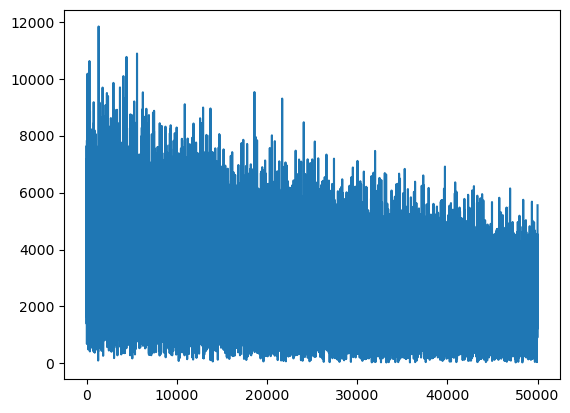

In [134]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.0000005, 
                               epsilon = 0.0000001, method = "sgd", max_iterations = 50000)
solver.fit()